# Ch9 Advanced deep learning for computer vision -1

計算機視覺的不同分支：圖像分類、圖像分割、目標檢測<br>
現代卷積網絡架構模式：殘差連接、批量歸一化、
深度可分離卷積<br>
可視化和解釋什麼的技術<br>
卷積網絡學習<br>


*regerence:<br>
作者github<br>
https://github.com/fchollet/deep-learning-with-python-notebooks <br>

*extra:<br>
hugging face<br>
https://huggingface.co/ <br>

上一章通過簡單模型（ Conv2D和MaxPooling2D層的堆棧）和一個簡單的用例（二值圖像分類）向您介紹了計算機視覺的深度學習。但是計算機視覺不僅僅是圖像分類！本章將深入探討更多樣化的應用程序和先進的最佳實踐。

9.1	三個基本的計算機視覺任務

到目前為止，我們專注於圖像分類模型：圖像進入，標籤出來。 “這張圖片可能包含一隻貓；這另一個可能包含一隻狗。”但圖像分類只是深度學習在計算機視覺中的幾種可能應用之一。一般來說，您需要了解三個基本的計算機視覺任務：


圖像分類 目標是為圖像分配一個或多個標籤。它可以是單標籤分類（圖像只能屬於一個類別，排除其他類別），也可以是多標籤分類（標記圖像所屬的所有類別，如圖 9.1 所示）。
例如，當您在 Google 照片應用程序上搜索關鍵字時，您會在後台查詢一個非常大的多標籤分類模型 一個包含 20,000 多個不同類別的模型，並在數百萬張圖像上進行了訓練。

圖像分割 目標是將圖像“分割”或“分割”成不同的區域，每個區域通常代表一個類別（如圖 9.1 所示）。例如，當 Zoom 或Google Meet 在視頻通話中顯示您身後的自定義背景時，它使用圖像分割模型以像素精度將您的臉與其背後的東西區分開來。

對象檢測 目標是在圖像中感興趣的對象周圍繪製矩形（稱為邊界框） ，並將每個矩形與一個類相關聯。例如，自動駕駛汽車可以使用物體檢測模型來監控汽車、行人和標誌。


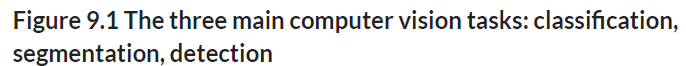

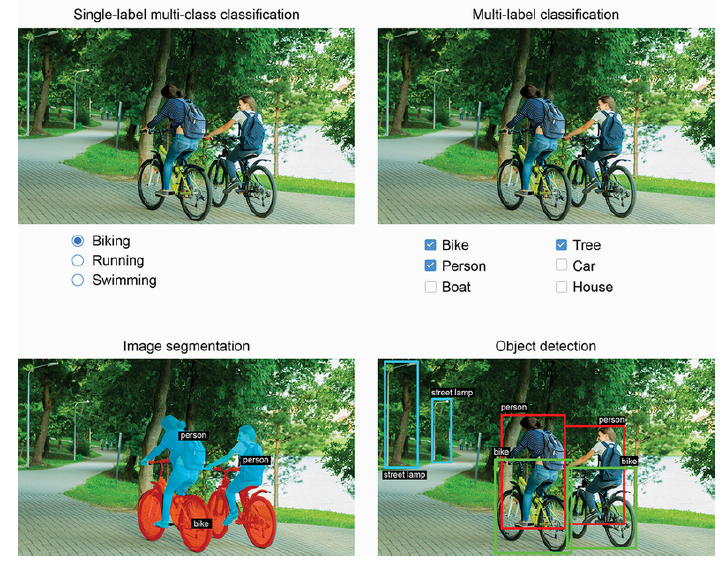

用於計算視覺的深度學習還包括除了這三個之外的一些一些更高級的任務, 如圖像相似度評分（估計兩個圖像在視覺上的相似程度）,關鍵點檢測（精確定位圖像中感興趣的屬性，例如面部特徵）、姿勢估計、3D網格估計等。但首先，圖像分類、圖像分割和對象檢測是每個機器學習工程師都應該熟悉的基礎。大多數計算機視覺應用程序歸結為這三個之一。


您已經在前一章中看到了圖像分類的實際應用。
接下來，讓我們深入研究圖像分割。這是一種非常有用且用途廣泛的技術， 您可以直接使用到目前為止所學的知識來處理它。



請注意，我們不會介紹對象檢測，因為它對於一本入門書來說太專業和太複雜 了。但是，您可以查看 keras.io 上的 RetinaNet 示例，該示例展示瞭如何在大約 450 行代碼（https://keras.io/examples/vision/retinanet/ ）中在 Keras 中從頭構建和訓練對象檢測模型）。


# 9.2	圖像分割示例

深度學習圖像分割是使用模型為圖像中的每個像素分配一個類別， 從而將圖像分割成不同的區域（例如“背景”和“前景”，或“道路”、“汽車”和“人行道”）。這種通用技術可用於為圖像和視頻編輯、自動駕駛、機器人、醫學成像等領域的各種有價值的應用。

您應該了解兩種不同風格的圖像分割：
語義分割，其中每個像素被獨立地分類為一個語義類別，如“貓”。如果圖像中有兩隻貓，則對應的像素都映射到相同的通用“貓”類別（見圖 9.2）。
實例分割，它不僅要按類別對圖像像素進行分類，還要解析出單個對象實例。在包含兩隻貓的圖像中，實例分割會將“cat 1”和“cat 2”視為兩個獨立的像素類別（見圖 9.2）。


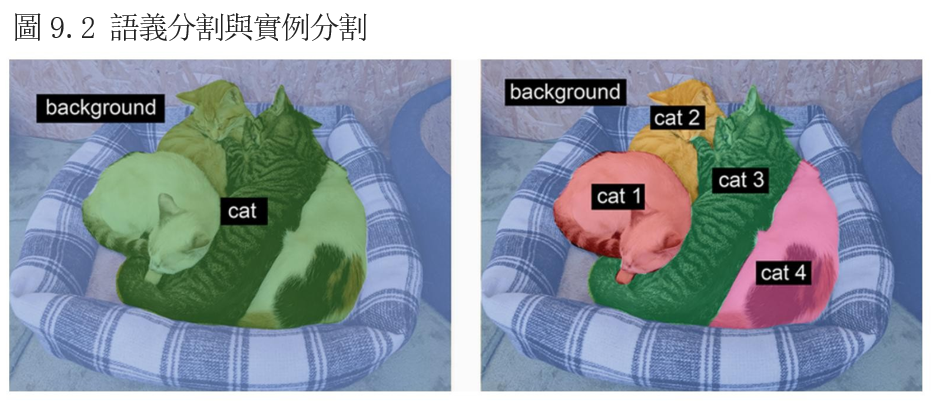

在這個例子中，我們將專注於語義分割：我們將再次查看貓和狗的圖像，這一次我們將學習如何區分主要主題及其背景。

我們將使用 Oxford‑IIIT Pets 數據集
( www.robots.ox.ac.uk/~vgg/data/pets/ )，其中包含 7,390 張各種貓狗的圖片，以及每張圖片的前景‑背景分割掩碼。分割掩碼是標籤的圖像分割等價物：


它是與輸入圖像大小相同的圖像，具有單個顏色通道，其中每個整數值對應於輸入圖像中相應像素的類別。在我們的例子中，我們的分割掩碼的像素可以取三個整數值之一：


1（前景）<br> 
2（背景）<br>
3（輪廓）<br>

讓我們首先使用wget和tar shell 實用程序下載和解壓縮我們的數據集：

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-11-16 02:15:55--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-11-16 02:15:56--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-11-16 02:15:56--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7

輸入的圖片以JPG文件形式存儲在images/文件夾下（如images/Abyssinian_1.jpg），對應的分割掩碼以同名PNG文件形式存儲在annotations/trimaps/ 文件夾（例如 annotations/trimaps/ Abyssinian_1.png）。
讓我們準備輸入文件路徑列表，以及對應的掩碼文件路徑列表：

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

現在，這些輸入之一及其掩碼是什麼樣的？讓我們快速瀏覽一下。這是一個示例圖像：

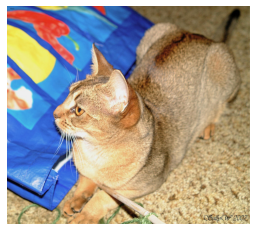

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

這是它對應的目標

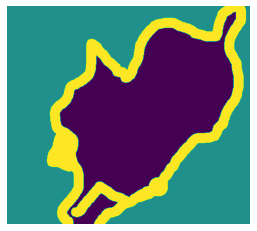

In [ ]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

現在是時候定義我們的模型了：

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

該模型的前半部分非常類似於您用於圖像分類的那種卷積網絡：一堆Conv2D層，過濾器大小逐漸增加。我們將圖像下採樣 3 次，每次降低 2 倍，最終得到大小為(25, 25, 256)的激活。前半部分的目的是將圖像編碼為較小的特徵圖，其中每個空間位置（或像素）包含有關原始圖像的大空間塊的信息。您可以將其理解為一種壓縮。


該模型的前半部分與您之前看到的分類模型之間的一個重要區別是我們進行下採 樣的方式：在上一章的分類卷積網絡中，我們使用MaxPooling2D層對特徵圖進行下採樣。在這裡，我們通過向每個其他卷積層添加步幅來進行下採樣（如果您不記得卷積步幅如何工作的細節，請參閱第 8.1.1 節中的“了解卷積步幅”）。我們這樣做是因為在圖像分割的情況下，我們非常關心圖像中信息的空間位置，因為我 們需要生成每個像素的目標掩碼作為模型的輸出。當您進行 2 × 2 最大池化時，您完全破壞了位置信息

在每個池化窗口內：每個窗口返回一個標量值，零知道該值來自窗口中的四個位置中的哪一個。因此，雖然最大池化層在分類任務中表現良好，但對於分割任務，它們會對我們造成很大的傷害。同時，跨步卷積在對特徵圖進行下採樣方面做得更好，同 時保留了位置信息。


在本書中，你會注意到我們傾向於在任何關心特徵位置的模型中使用步幅而不是最大池，例如第 12 章中的生成模型。

模型的後半部分是一堆Conv2DTranspose層。
那些是什麼？好吧，模型前半部分的輸出是形狀為(25, 25, 256)的特徵圖，但我們希望最終輸出與目標掩碼(200, 200, 3)具有,相同的形狀。
因此，我們需要應用一種與迄今為止應用的變換相反的方法 對特徵圖進行上採樣而不是下採樣。這就是Conv2DTranspose層的目的：您可以將其視為一種學習上採樣的捲積層。如果你有一個形狀的輸入（100，100, 64)，然後你通過層Conv2D(128, 3,strides=2,padding="same")，你得到一個形狀的輸出(50,50,128)。
如果你通過Cenv2DTranpose Layer (64,3,strides=2,padding="same")進行輸出，你得到該輸出形狀(100,100,64)，大小就跟原始輸入一樣。
因此，在通過一堆Conv2D層將我們的輸入壓縮為形狀為(25, 25, 256)的特徵圖之後，我們可以簡單地應用相應的Conv2DTranspose層序列來返回形狀為(200, 200, 3)的圖像。


我們現在可以編譯並擬合我們的模型：

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
 93/100 [==========================>...] - ETA: 6:16 - loss: 7.7284

讓我們展示一下我們的訓練和驗證損失（見圖 9.5）：

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

你可以看到我們在 epoch 25 左右開始過擬合。讓我們根據驗證損失重新加載我們表現最好的模型，並演示如何使用它來預測分割掩碼（見圖 9.6）：

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

我們預測的蒙版中有幾個小瑕疵，是由前景和背景中的幾何形狀引起的。儘管如此，我們的模型似乎運行良好。

至此，在第 8 章和第 9 章開頭，您已經學習瞭如何執行圖像分類和圖像分割的基礎知識：您已經可以用您所知道的完成很多工作。然而，經驗豐富的工程師為解決現實世界問題而開發的捲積網絡並不像我們以前那樣簡單
 
到目前為止在我們的演示中使用。您仍然缺乏基本的心智模型和思維過程，使專家能夠就如何組合最先進的模型做出快速準確的決定。為了彌合這一差距，您需要了解架構模式。讓我們潛入水中。


# 9.3	現代卷積網絡架構模式

模型的“架構”是進入的選擇的總和
創建它：使用哪些層，如何配置它們，以及以何種方式連接它們。這些選擇定義了模型的假設空間：梯度下降可以搜索的可能函數空間，由模型的權重參數化。像特徵工程一樣， 一個好的假設空間編碼你對手頭問題及其解決方案的先驗知識。例如，使用卷積層意味 著您提前知道輸入圖像中存在的相關模式是ŋ移不變的。為了有效地從數據中學習，您需要對您正在尋找的內容做出假設。


模型架構通常是成功與否的區別。如果您做出不適當的架構選擇，您的模型可能會陷入次優指標，並且沒有多少訓練數據可以保存它。相反，一個好的模型架構將加速學習，並使您的模型能夠有效地利用可用的訓練數據，從而減少對大型數據集的需求。一個好的模型架構是減少搜索空間的大小或以其他方式使其更容易收斂到搜索空間的好點的架構。


就像特徵工程和數據管理一樣，模型架構就是為了讓梯度下降更容易解決問題。

請記住，梯度下降是一個非常愚蠢的搜索過程，因此它需要它所能獲得的所有幫助。


模型架構與其說是科學，不如說是一門藝術。經驗豐富的機器學習工程師能夠在第一次嘗試時直觀地拼湊出高性能模型，而初學者通常很難創建一個完全可以訓練的模型。這裡的關鍵詞很直觀：沒有人可以清楚地解釋什麼有效，什麼無效。專家依賴模式匹配，這是他們通過豐富的實踐經驗獲得的能力。你將在本書中培養自己的直覺。然而，這並不是全部


直覺也是實際科學的方式並不多，但與任何工程學科一樣，都有最佳實踐。

在以下部分中，我們將回顧一些基本的捲積網絡架構最佳實踐：特別是
殘差連接、批量歸一化和可分離卷積。一旦掌握瞭如何使用它們，您將能夠構建高效的圖像模型。我們會將它們應用於我們的貓與狗分類問題。


讓我們從鳥瞰圖開始：系統架構的模塊化‑層次‑重用 (MHR) 公式。

## 9.3.1	模塊化、層次結構和重用



如果你想讓一個複雜的系統更簡單，你可以應用一個通用的方法：只需將你無定形的複雜湯構建成模塊，將模塊組織成層次結構，並開始在多個地方適當地重用相同的模塊（“重用”在這種情況下是抽象的另一個詞）。這就是MHR 公式（模塊化‑層次結構‑重用），它是幾乎每個領域的系統架構的基礎

使oogle用“架構”。它是任何有意義的複雜系統組織的核心，無論是大
教堂、你自己的身體、美國海軍還是 Keras 代碼庫（見圖 9.7）。


圖 9.7 複雜系統遵循層次結構並組織成不同的模塊，這些模塊可以多次重複使用（例如你的四個肢體，它們都是同一個藍圖的變體，或者你的 20 個“手指”）。

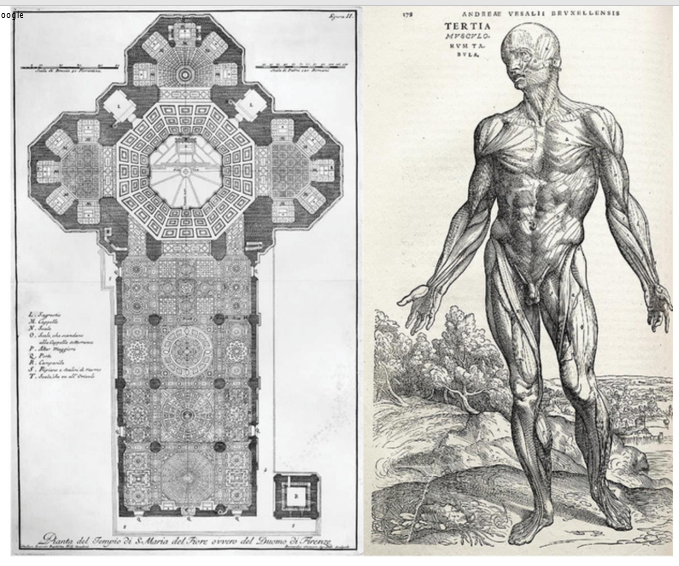

層次結構，並且您不會兩次重新實現同一事物，而是依賴可重用的類和函數。如果你按照這些原則分解你的代碼，你可以說你在做“軟件架構”。


深度學習本身就是通過梯度下降將這個秘訣應用於持續優化：你採用經典的優化技術（連續函數空間上的梯度下降），並將搜索空間構造成模塊（層），組織成一個深層層次結構（通常只是一個堆棧，最簡單的層次結構），您可以在其中重用任何東西（例如，卷積都是關於在不同的空間位置重用相同的信 息）。


同樣，深度學習模型架構主要是關於巧妙地利用模塊化、層次結構和重用。你會注 意到所有流行的捲積網絡架構不僅被結構化為層，它們被結構化為重複的層組（稱為“塊”或“模塊”）。例如，我們在前一章中使用的流行 VGG16 架構被構造成 重複的“conv、conv、max pooling”塊（見圖 9.8）。

此外，大多數卷積網絡通常具有類似金字塔的結構（特徵層次結構）。
例如，回想一下我們在構建的第一個卷積網絡中使用的捲積濾波器數量的進展
上一章：32、64、128。過濾器的數量隨著層的深度而增加，而特徵圖的大小則相應地縮小。您會在 VGG16 模型的塊中註意到相同的模式（見圖 9.8）。



圖 9.8 VGG16 架構：注意重複層塊和特徵圖的金字塔狀結構

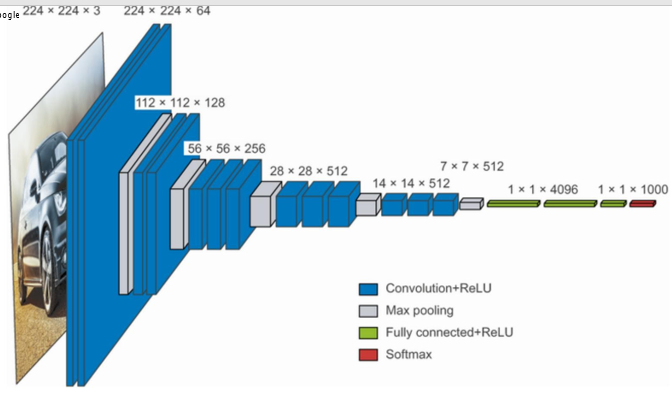

更深的層次結構本質上是好的，因為它們鼓勵特徵重用，因此是抽象的。通常，較深的窄層堆棧比淺堆棧的大層性能更好。

但是，由於梯度消失的問題，您可以堆疊層的深度是有限的。這將我們引向我們的第一個基本模型架構模式：殘差連接。


深度學習架構通常比設計更進化 它們是通過反复嘗試和選擇似乎可行的方法而開發的。就像在生物系統中一樣，如果您進行任何復雜的實驗性深度學習設置，您很可能可以移除一些模塊（或用隨機模 塊替換一些經過訓練的特徵）而不會損失性能。

深度學習研究人員面臨的激勵使情況變得更糟：通過使系 統比必要的複雜，他們可以使其看起來更有趣或更新穎，從而增加他們通過同行評審過程獲得論文的機會。如果您閱讀大量深度學習論文，您會注意到它們通常在風格和內容上都針對同行評審進行了優化，這會嚴重損害解釋的清晰度和結果的可靠性。例如，深度學習論文中的數學很少用於清晰地形式化概念或得出不明顯的結果 相反，它得到了被用作嚴肅的信號，就像推銷員穿昂貴的西裝。



研究的目標不應該僅僅是發表，而應該是產生可靠的知識。
至關重要的是，了解系統中的因果關係是生成可靠知識的最直接方法。還有一種非常省力的方法來研究因果關係：消融研究。消融研究包括系統地嘗試移除系統的某些部分 使其更簡單 以確定其性能的實際來源。


如果你發現 X + Y + Z 給你很好的結果，也可以試試 X、Y、Z、X + Y、X + Z 和 Y + Z，看看會發生什麼。


如果您成為深度學習研究人員，請消除研究過程中的噪音：為您的模型進行消融研究。
總是問：“有沒有更簡單的解釋？這種增加的複雜性真的有必要嗎？為什麼？”


## 9.3.2	殘差連結

您可能知道電話遊戲，在英國也稱為中國耳語，在法國也稱為téléphonearabe，初始消息在玩家耳邊耳語，然後玩家在下一個玩家耳邊耳語，依此類推.最後的消息最終與其原始版本幾乎沒有相似之處。這是一個有趣的比喻，用於在嘈雜的信道上順序傳輸中發生的累積錯誤。


碰巧的是，順序深度學習模型中的反向傳播與電話遊戲非常相似。你有一系列函數，比如這個：

y=f4(f3(f2(f1(x))))

游戲的名稱是根據f4的輸出上記錄的誤差（模型的損失）來調整鏈中每個函數的參數。要調整f1 ，您需要滲透錯誤信息通過f2鏈引入,f3,和f4 。然而，每個連續的功能在了一些噪聲。如果你的函數鏈太深，這種噪音開始壓倒梯度信息，並且反向傳播停止工作。你的模型根本不會訓練。這就是消失梯度問題。


解決方法很簡單：只需強制鏈中的每個函數都是非破壞性的 保留信息的無噪音版本包含在前面的輸入中。實現這一點的最簡單方法是使用殘差連接。這非常簡單：只需將層或層塊的輸入添加回其輸出（見圖 9.9）。殘差連接充當破壞性或噪聲塊（例如包含relu激活或丟失層的塊）周圍的信息捷徑，使來自早期層的誤差梯度信息能夠 通過深度網絡無噪聲地傳播。該技術於 2015 年與 ResNet 系列模型（由 He 等人 在 Microsoft 開發）一起引入。


1 Kaiming He 等人，“用於圖像識別的深度殘差學習，計算機視覺和模式識別”會議（2015 年）， https://arxiv.org/abs/1512.03385 

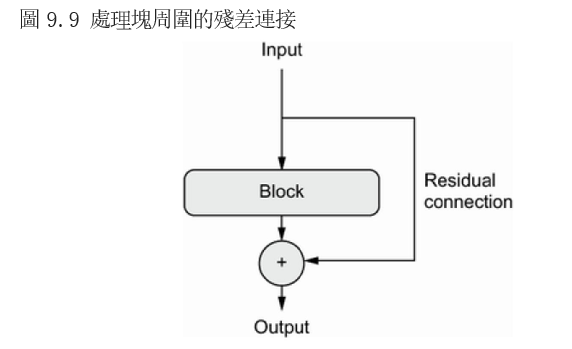

在實踐中，您將按如下方式實現殘差連接。

### Listing 9.1 A residual connection in pseudocode
x = ... #1 <br>
residual = x #2 <br>
x = block(x) #3 <br>
x = add([x, residual]) #4 <br>

請注意，將輸入添加回模塊的輸出意味著輸出應該與輸入具有相同的形狀。但是，如果您的塊包含過濾器數量增加的捲積層或最大池化層，則情況並非如此。在這種情況下，使用沒有激活的 1 × 1 Conv2D層將殘差線性投影到所需的輸出形狀（參見清單 9.2）。您通常會在目標塊的捲積層中使用padding= same 以避免由於填充而導致空間下採樣，並且您會在殘差投影中使用步幅來匹配由最大池化層引起的任何下採樣（請參閱清單 9.3)。

## Listing 9.2 Residual block where the number of fi lters changes

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

## Listing 9.3 Case where the target block includes a max poolinglayer

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

為了使這些想法更具體，這裡有一個簡單的捲積網絡示例，它被構 造成一系列塊，每個塊由兩個卷積層和一個可選的最大池化層組成，每個塊周圍都有一個殘差連接：

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

使用殘差連接，您可以構建任意深度的網絡，而不必擔心梯度消失。
現在讓我們繼續討論下一個基本的捲積網絡架構模式：批量標準化。


9.3.3	批量標準化
歸一化是一類廣泛的方法，旨在使機器學習模型看到的不同樣本彼此更加相似，這有助於模型很好地學習和泛化到新數據。最常見的數據歸一化形式是您在本書中已經多次看到的一種形式：通過從數據中 減去均值來使數據以零為中心，並通過將數據除以其標準差來給數據 一個單位標準差。實際上，這假設數據遵循正態（或高斯）分佈，並確保該分佈居中並縮放到單位方差：


本書之前的示例在將數據輸入模型之前對其進行了標準化。但是在網絡操作的 每次轉換之後，數據歸一化可能是有意義的：即使進入Dense或Conv2D網絡的數據具有 0 均值和單位方差，也沒有理由先驗地期望即將到來的數據會出現這種情況出去。標準化中間激活有幫助嗎？

批量標準化就是這樣做的。它是Ioffe 於 2015 年引入的一種
層（ Keras中的BatchNormalization ），它可以自適應地對數據進行歸練期間，它一使化用，當即前使批是次均數值據和的S均ze值g和ed方y；差訓進練行期歸間一方化差隨時間變化。在訓
樣本，並且在推理期間（當可能無法獲得足夠大的代表性數據批次
時），它使用訓練期間看到的數據的批次均值和方差的指數移動ŋ均值。


2 Sergey Ioffe 和 Christian Szegedy，“批量標準化：通過減少內部協變量偏移來加速深度網絡訓練，學習(2015)， https://arxiv.org/abs/1502.03167 。屆國際機器會議論文集



儘管原始論文指出批量歸一化是通過“減少內部協變量偏移來進行的，但為什麼批量歸一化會有所幫助。有各種各樣的假設，但沒沒有有人確真定正性確。切你地會知發道現深度學習中的許多事情都是如此 深度學習不是一門精確的科學，而是一組不斷變化的、憑經驗得出的工程最佳實踐，由不可靠的敘述交織在一起。有時您會覺得手頭的書告訴您如何做某事，但並不能令人滿意地說明它為什麼起作用：那是因為我們知道如何做，但我們不知道為什麼。只要有可靠的解釋，我一定會提到它。批量標準化不是其中一種情況。


在實踐中，批量歸一化的主要效果似乎是它有助於梯度傳播 很像殘差連接 因此允許更深的網絡。一些非常深的網絡只有在包含多個BatchNormalization層時才能被訓練。

 例如，批量標準化在許多
 
與 Keras 一起打包的高級 convnet 架構，例如
如 ResNet50、EfficientNet 和 Xception。


BatchNormalization層可以在任何層之後使用 Dense,
二維卷積
, ETC。：


x= ... <br>
x= layers.Conv2D(32,3, use_bias=False)(x) <br>
x= layers.BatchNormalization()(x) <br>

筆記
Dense和Conv2D都涉及一個偏置向量，一個學習變量其目的是使層仿射而不是純粹線性的。例如， Conv2D示意性地返回y =轉換（x，內核）+偏差	, 並且密集返回y = dot(x, 
零上的偏差，所以在.使因為用B規a範tc化hN步o驟rm將a關liz注at內io核n時）+不將再層需的要輸偏出差集向中量在，
並且可以通過選項use_bias=False在沒有它的情況下創建層。這使得層稍微瘦了。


重要的是，我通常建議將前一層的激活放在批量標準化層之後（儘管這仍然是一個爭論的主題）。因此，不要執行清單 9.4 中顯示的操作，而是執行清單 9.5 中顯示的操作。
